<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/youtube/gpu/Mandlebrot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Mandelbrot Plots with an NVIDIA RTX A6000

[Jeff Heaton](https://www.youtube.com/channel/UCR1-GEpyOPzT2AO4D_eifdw)



In [ ]:
import tensorflow as tf
import numpy as np

import PIL.Image
from io import BytesIO
from IPython.display import Image, display

def render(a):
  a_cyclic = (a*0.3).reshape(list(a.shape)+[1])
  img = np.concatenate([10+20*np.cos(a_cyclic),
                        30+50*np.sin(a_cyclic),
                        155-80*np.cos(a_cyclic)], 2)
  img[a==a.max()] = 0
  a = img
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  return PIL.Image.fromarray(a)

#@tf.function
def mandelbrot_helper(grid_c, current_values, counts,cycles):
  
  for i in range(cycles):
    temp = current_values*current_values + grid_c
    not_diverged = tf.abs(temp) < 4
    current_values.assign(temp),
    counts.assign_add(tf.cast(not_diverged, tf.float32))

def mandelbrot(render_size,center,zoom,cycles):
  f = zoom/render_size[0]
  real_start = center[0]-(render_size[0]/2)*f
  real_end = real_start + render_size[0]*f 
  imag_start = center[1]-(render_size[1]/2)*f
  imag_end = imag_start + render_size[1]*f 

  real_range = tf.range(real_start,real_end,f,dtype=tf.float64)
  imag_range = tf.range(imag_start,imag_end,f,dtype=tf.float64)
  real, imag = tf.meshgrid(real_range,imag_range)
  grid_c = tf.constant(tf.complex(real, imag))
  current_values = tf.Variable(grid_c)
  counts = tf.Variable(tf.zeros_like(grid_c, tf.float32))

  mandelbrot_helper(grid_c, current_values,counts,cycles)
  return counts.numpy()

# Plot a Single Image

(1920, 1080)


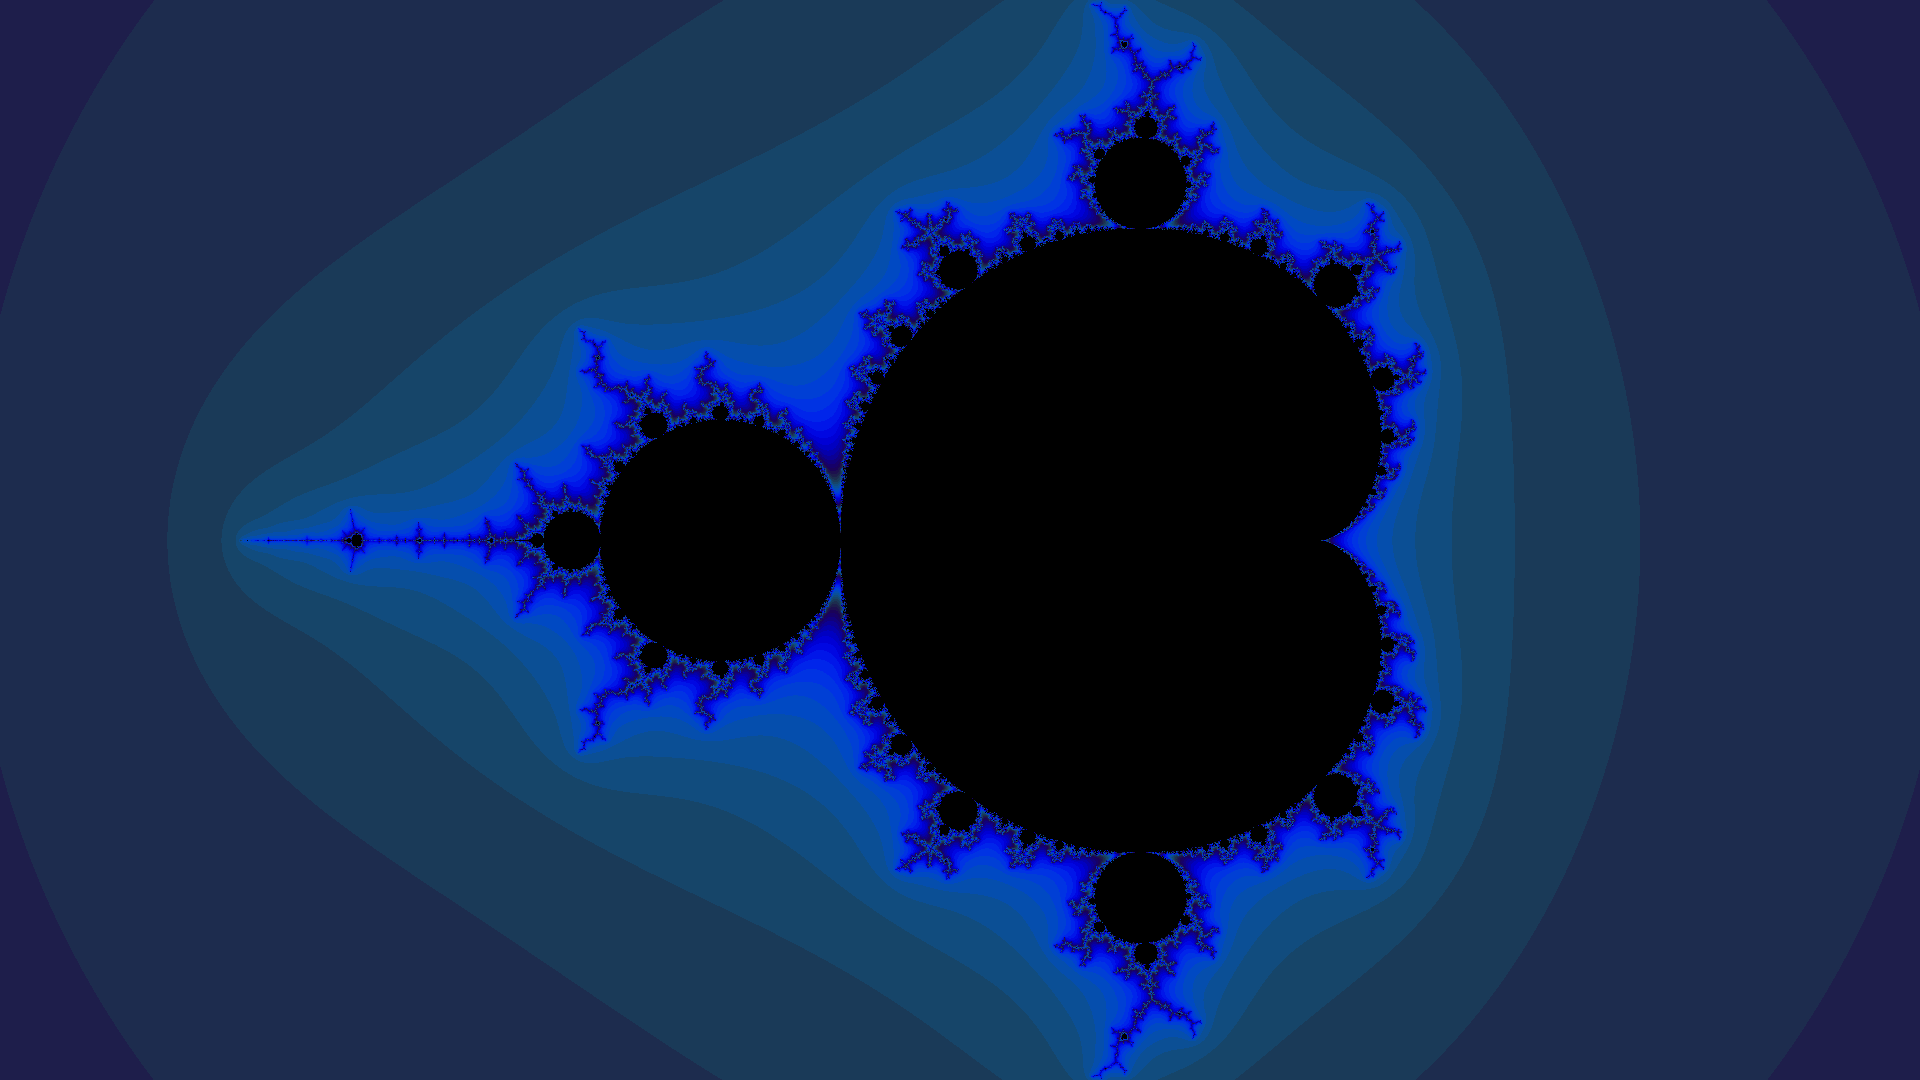

In [3]:
counts = mandelbrot(
    #render_size=(30720,17280), # 32K
    #render_size=(15360,8640), # 16K
    #render_size=(7680,4320), # 8K
    #render_size=(3840,2160), # 4K
    render_size=(1920,1080), # HD
    center=(-0.5,0),
    zoom=4,
    cycles=200
)  
img = render(counts)
print(img.size)
img

#img.save("test.png")


# Render a Zoom Video

In [ ]:
!mkdir tmp

In [ ]:
from tqdm import tqdm

zoom = 1.0
for i in tqdm(range(3000)):
  counts = mandelbrot(
      (3840,2160),
      #(1920,1200),
      (-0.7,0.35),
      zoom,
      2000
  )
  zoom *=0.99
  img = render(counts)
  img.save(f"/content/tmp/img-{i}.png")

print(zoom)

Package the frames to a MP4.

In [ ]:
!ffmpeg -r 30 -i /content/tmp/img-%d.png -vcodec mpeg4 -b 5000k -y movie.mp4

Download the movie

In [ ]:
from google.colab import files
files.download('movie.mp4') 
#files.download('/content/tmp/img-300.png')